In [1]:
import gym
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

/var/folders/9j/g8mv42fn5p13f5g2f8mxlplc0000gp/T/ipykernel_91005/3628126482.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
NUM_ITERATIONS = 100_000

In [3]:
env = gym.make("Blackjack-v1", natural=True)
observation, info = env.reset(seed=42)

for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()
env.close()

In [4]:
observation, info = env.reset()
observation

(20, 2, True)

# Часть 1

- Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
- Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.
- Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


### Простая стратегия

In [5]:
env = gym.make("Blackjack-v1", natural=True)

In [6]:
def get_action(observation):
    """Return 1 if combination less than 19 otherwise 0."""

    action = 0
    if observation[0] < 19:
        action = 1

    return action


def check_simple_strategy():

    rewards = []

    for _ in tqdm(range(NUM_ITERATIONS), total=NUM_ITERATIONS):

        observation, info = env.reset()

        terminated = False
        while not terminated:

            action = get_action(observation)

            observation, reward, terminated, truncated, info = env.step(action)

        rewards.append(reward)

    return rewards

In [7]:
rewards = check_simple_strategy()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 12624.23it/s]


In [8]:
mean_reward = np.mean(rewards)
print(f"Средняя награда для простой стратегии: {mean_reward}")

Средняя награда для простой стратегии: -0.20026


### Q-learning

In [9]:
ACTIONS = [False, True]
MIN_PLAYER_CARD_VALUE = 4
MAX_PLAYER_CARD_VALUE = 31
MIN_DEALER_CARD_VALUE = 1
MAX_DEALER_CARD_VALUE = 10

In [10]:
def get_all_states():
    states = []

    for player_val in range(MIN_PLAYER_CARD_VALUE, MAX_PLAYER_CARD_VALUE + 1):
        for dealer_val in range(MIN_DEALER_CARD_VALUE, MAX_DEALER_CARD_VALUE + 1):
            states.append((player_val, dealer_val, False))
            if 12 <= player_val <= 21:
                states.append((player_val, dealer_val, True))

    return states

In [11]:
STATES = get_all_states()

In [12]:
STATES_IDX = {s: i for i, s in enumerate(STATES)}

In [13]:
def get_action(Q, state_idx):
    pi = np.argmax(Q, axis=1)

    if np.random.rand() > epsilon:
        return pi[state_idx]

    return np.random.randint(len(ACTIONS))


def q_learning(alpha, epsilon, gamma, num_iterations=NUM_ITERATIONS):
    Q = np.zeros((len(STATES), len(ACTIONS)))

    for _ in tqdm(
        range(num_iterations),
        total=num_iterations,
        desc=f"alpha={alpha}, epsilon={epsilon}, gamma={gamma}",
    ):

        observation, info = env.reset()
        state_idx = STATES_IDX[observation]

        terminated = False
        while not terminated:
            action = get_action(Q, state_idx)

            observation, reward, terminated, truncated, info = env.step(action)

            next_state_idx = STATES_IDX[observation]

            Q[state_idx][action] = Q[state_idx][action] + alpha * (
                reward + gamma * np.max(Q[next_state_idx]) - Q[state_idx][action]
            )

            observation = next_state_idx

    return Q

In [14]:
alpha = 0.01
epsilon = 0.1
gamma = 1
Q = q_learning(alpha, epsilon, gamma)

alpha=0.01, epsilon=0.1, gamma=1: 100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:09<00:00, 10533.83it/s]


In [15]:
def check_q_learning_strategy(Q, num_iterations=NUM_ITERATIONS):

    pi = np.argmax(Q, axis=1)

    rewards = []

    for _ in range(num_iterations):

        observation, info = env.reset()
        state_idx = STATES_IDX[observation]

        terminated = False
        while not terminated:

            action = pi[state_idx]

            observation, reward, terminated, truncated, info = env.step(action)

            state_idx = STATES_IDX[observation]

        rewards.append(reward)

    return rewards

In [16]:
rewards = check_q_learning_strategy(Q)

In [17]:
mean_reward = np.mean(rewards)
print(f"Средняя награда (q-learning): {mean_reward}")

Средняя награда (q-learning): -0.11983


In [18]:
epsilon_lst = np.arange(0.8, 1, 0.1)
alpha_lst = np.arange(0.001, 0.005, 0.001)
gamma = 1

params = []
mean_rewards = []
for epsilon in epsilon_lst:
    for alpha in alpha_lst:
        Q = q_learning(alpha, epsilon, gamma)
        rewards = check_q_learning_strategy(Q)
        mean_reward = np.mean(rewards)
        
        params.append((alpha, epsilon, gamma))
        mean_rewards.append(mean_reward)

alpha=0.004, epsilon=0.9, gamma=1: 100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:09<00:00, 10886.17it/s]


In [19]:
idx = np.argmax(mean_rewards)
best_alpha, best_epsilon, best_gamma = params[idx]
print(f"Best params: alpha={best_alpha}, epsilon={best_epsilon}, gamma={best_gamma}")

Best params: alpha=0.004, epsilon=0.8, gamma=1


In [20]:
Q = q_learning(best_alpha, best_epsilon, best_gamma)
rewards = check_q_learning_strategy(Q)
mean_reward = np.mean(rewards)
print(f"Средняя награда с подобранными параметрами (q-learning): {mean_reward}")

alpha=0.004, epsilon=0.8, gamma=1: 100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:09<00:00, 10895.24it/s]


Средняя награда с подобранными параметрами (q-learning): -0.08431


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [03:40<00:00,  7.36s/it]


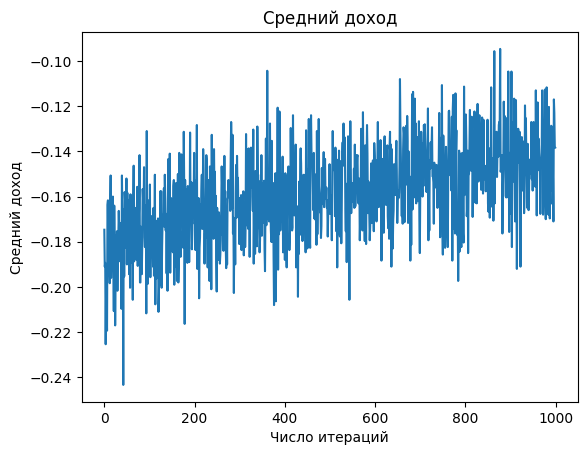

In [23]:
def plot(num_iterations=1000, k=30):
    rewards_lst = []
    alpha, epsilon, gamma = best_alpha, best_epsilon, best_gamma
    for _ in tqdm(range(k), total=k):
        one_iter_rewards = []
        Q = np.zeros((len(STATES), len(ACTIONS)))

        for _ in range(num_iterations):

            observation, info = env.reset()
            state_idx = STATES_IDX[observation]

            terminated = False
            while not terminated:
                action = get_action(Q, state_idx)

                observation, reward, terminated, truncated, info = env.step(action)

                next_state_idx = STATES_IDX[observation]

                Q[state_idx][action] = Q[state_idx][action] + alpha * (
                    reward + gamma * np.max(Q[next_state_idx]) - Q[state_idx][action]
                )

                observation = next_state_idx
                
            rewards = check_q_learning_strategy(Q, 100)
            one_iter_rewards.append(np.mean(rewards))
            
        rewards_lst.append(one_iter_rewards)
        
    mean_rewards_lst = np.mean(rewards_lst, axis=0)

    plt.title("Средний доход")
    plt.plot(range(num_iterations), mean_rewards_lst)
    plt.xlabel("Число итераций")
    plt.ylabel("Средний доход")
    plt.show()
    
plot()

# Часть 2

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
- double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

4. Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.
5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [24]:
from typing import Optional

import gym
from gym import spaces


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """
    Blackjack is a card game where the goal is to beat the dealer by obtaining cards
    that sum to closer to 21 (without going over 21) than the dealers cards.

    ### Description
    Card Values:

    - Face cards (Jack, Queen, King) have a point value of 10.
    - Aces can either count as 11 (called a 'usable ace') or 1.
    - Numerical cards (2-9) have a value equal to their number.

    This game is played with an infinite deck (or with replacement).
    The game starts with the dealer having one face up and one face down card,
    while the player has two face up cards.

    The player can request additional cards (hit, action=1) until they decide to stop (stick, action=0)
    or exceed 21 (bust, immediate loss).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust, the player wins.
    If neither the player nor the dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.

    ### Action Space
    There are two actions: stick (0), and hit (1).

    ### Observation Space
    The observation consists of a 3-tuple containing: the player's current sum,
    the value of the dealer's one showing card (1-10 where 1 is ace),
    and whether the player holds a usable ace (0 or 1).

    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (http://incompleteideas.net/book/the-book-2nd.html).

    ### Rewards
    - win game: +1
    - lose game: -1
    - draw game: 0
    - win game with natural blackjack:

        +1.5 (if <a href="#nat">natural</a> is True)

        +1 (if <a href="#nat">natural</a> is False)

    ### Arguments

    ```
    gym.make('Blackjack-v1', natural=False, sab=False)
    ```

    <a id="nat">`natural=False`</a>: Whether to give an additional reward for
    starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

    <a id="sab">`sab=False`</a>: Whether to follow the exact rules outlined in the book by
    Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.
    If the player achieves a natural blackjack and the dealer does not, the player
    will win (i.e. get a reward of +1). The reverse rule does not apply.
    If both the player and the dealer get a natural, it will be a draw (i.e. reward 0).

    ### Version History
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        self.render_mode = render_mode

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        elif action == 2:
            self.player.append(draw_card(self.np_random))
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = 2 * cmp(score(self.player), score(self.dealer))
        else:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), reward, terminated, False, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)

        _, dealer_card_value, _ = self._get_obs()

        suits = ["C", "D", "H", "S"]
        self.dealer_top_card_suit = self.np_random.choice(suits)

        if dealer_card_value == 1:
            self.dealer_top_card_value_str = "A"
        elif dealer_card_value == 10:
            self.dealer_top_card_value_str = self.np_random.choice(["J", "Q", "K"])
        else:
            self.dealer_top_card_value_str = str(dealer_card_value)

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), {}

    def close(self):
        if hasattr(self, "screen"):
            import pygame

            pygame.display.quit()
            pygame.quit()

In [25]:
env = BlackjackEnv(natural=True)

In [26]:
ACTIONS = [0, 1, 2]

def get_all_states():
    states = []

    for player_val in range(MIN_PLAYER_CARD_VALUE, MAX_PLAYER_CARD_VALUE + 1):
        for dealer_val in range(MIN_DEALER_CARD_VALUE, MAX_DEALER_CARD_VALUE + 1):
            states.append((player_val, dealer_val, 0))
            if 12 <= player_val <= 21:
                states.append((player_val, dealer_val, 1))
                states.append((player_val, dealer_val, 2))

    return states

In [27]:
STATES = get_all_states()

In [28]:
STATES_IDX = {s: i for i, s in enumerate(STATES)}

In [29]:
epsilon_lst = np.arange(0.8, 1, 0.1)
alpha_lst = np.arange(0.001, 0.005, 0.001)
gamma = 1

params = []
mean_rewards = []
for epsilon in epsilon_lst:
    for alpha in alpha_lst:
        Q = q_learning(alpha, epsilon, gamma)
        rewards = check_q_learning_strategy(Q)
        mean_reward = np.mean(rewards)
        
        params.append((alpha, epsilon, gamma))
        mean_rewards.append(mean_reward)

idx = np.argmax(mean_rewards)
best_alpha, best_epsilon, best_gamma = params[idx]
print(f"Best params: alpha={best_alpha}, epsilon={best_epsilon}, gamma={best_gamma}")

alpha=0.004, epsilon=0.9, gamma=1: 100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:09<00:00, 10687.75it/s]


Best params: alpha=0.003, epsilon=0.8, gamma=1


In [30]:
Q = q_learning(best_alpha, best_epsilon, best_gamma)
rewards = check_q_learning_strategy(Q)
mean_reward = np.mean(rewards)
print(f"Средняя награда  c  double (q-learning): {mean_reward}")

alpha=0.003, epsilon=0.8, gamma=1: 100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:09<00:00, 10675.81it/s]


Средняя награда  c  double (q-learning): -0.028045


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [03:41<00:00,  7.38s/it]


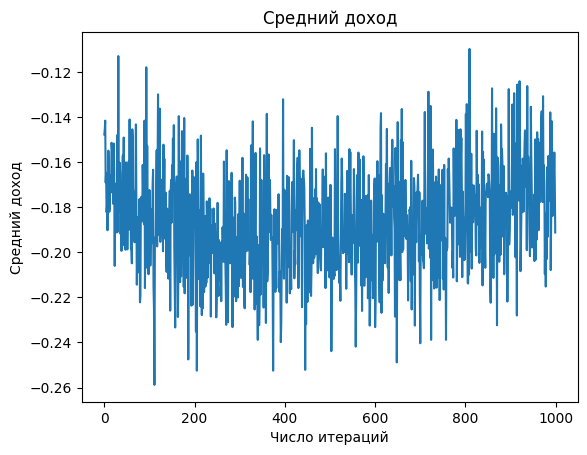

In [31]:
plot()

Средний доход должен увеличиваться, что на графике явно не видно. Возможно это связано с тем, что я уменьшил число раздач до 100 из-за того, что это требовало очень много времени посчитать для 10000 и тем более для 100000.

# Часть 3

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.  

6. Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).  
7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [32]:
from typing import Optional

import gym
from gym import spaces


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

card_counting_system = {
    1: -1,
    2: 0.5,
    3: 1,
    4: 1,
    5: 1.5,
    6: 1,
    7: 0.5,
    8: 0,
    9: -0.5,
    10: -1,
}



def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """
    Blackjack is a card game where the goal is to beat the dealer by obtaining cards
    that sum to closer to 21 (without going over 21) than the dealers cards.

    ### Description
    Card Values:

    - Face cards (Jack, Queen, King) have a point value of 10.
    - Aces can either count as 11 (called a 'usable ace') or 1.
    - Numerical cards (2-9) have a value equal to their number.

    This game is played with an infinite deck (or with replacement).
    The game starts with the dealer having one face up and one face down card,
    while the player has two face up cards.

    The player can request additional cards (hit, action=1) until they decide to stop (stick, action=0)
    or exceed 21 (bust, immediate loss).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust, the player wins.
    If neither the player nor the dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.

    ### Action Space
    There are two actions: stick (0), and hit (1).

    ### Observation Space
    The observation consists of a 3-tuple containing: the player's current sum,
    the value of the dealer's one showing card (1-10 where 1 is ace),
    and whether the player holds a usable ace (0 or 1).

    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (http://incompleteideas.net/book/the-book-2nd.html).

    ### Rewards
    - win game: +1
    - lose game: -1
    - draw game: 0
    - win game with natural blackjack:

        +1.5 (if <a href="#nat">natural</a> is True)

        +1 (if <a href="#nat">natural</a> is False)

    ### Arguments

    ```
    gym.make('Blackjack-v1', natural=False, sab=False)
    ```

    <a id="nat">`natural=False`</a>: Whether to give an additional reward for
    starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

    <a id="sab">`sab=False`</a>: Whether to follow the exact rules outlined in the book by
    Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.
    If the player achieves a natural blackjack and the dealer does not, the player
    will win (i.e. get a reward of +1). The reverse rule does not apply.
    If both the player and the dealer get a natural, it will be a draw (i.e. reward 0).

    ### Version History
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        
        self.deck = deck * 4
        self.count = 0

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        self.render_mode = render_mode

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            card = draw_card(self.np_random)
            self.player.append(card)
            self.count += card_counting_system[card]
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        elif action == 2:
            card = draw_card(self.np_random)
            self.player.append(card)
            self.count += card_counting_system[card]
            terminated = True
            self.count += self.dealer[1]
            while sum_hand(self.dealer) < 17:
                card = draw_card(self.np_random)
                self.dealer.append(card)
                self.count += card_counting_system[card]
            reward = 2 * cmp(score(self.player), score(self.dealer))
        else:  # stick: play out the dealers hand, and score
            terminated = True
            self.count += self.dealer[1]
            while sum_hand(self.dealer) < 17:
                card = draw_card(self.np_random)
                self.dealer.append(card)
                self.count += card_counting_system[card]
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), reward, terminated, False, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        if len(self.deck) < 15:
            self.deck = deck * 4
            self.count = 0

        super().reset(seed=seed)
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        
        for card in self.player:
            self.count += card_counting_system[card]
        self.count += card_counting_system[self.dealer[0]]

        _, dealer_card_value, _ = self._get_obs()

        suits = ["C", "D", "H", "S"]
        self.dealer_top_card_suit = self.np_random.choice(suits)

        if dealer_card_value == 1:
            self.dealer_top_card_value_str = "A"
        elif dealer_card_value == 10:
            self.dealer_top_card_value_str = self.np_random.choice(["J", "Q", "K"])
        else:
            self.dealer_top_card_value_str = str(dealer_card_value)

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), {}

    def close(self):
        if hasattr(self, "screen"):
            import pygame

            pygame.display.quit()
            pygame.quit()

    def draw_card(np_random):
        return int(np_random.choice(self.deck))


    def draw_hand(np_random):
        return [draw_card(np_random), draw_card(np_random)]

In [33]:
env = BlackjackEnv(natural=True)

In [34]:
epsilon_lst = np.arange(0.8, 1, 0.1)
alpha_lst = np.arange(0.001, 0.005, 0.001)
gamma = 1

params = []
mean_rewards = []
for epsilon in epsilon_lst:
    for alpha in alpha_lst:
        Q = q_learning(alpha, epsilon, gamma)
        rewards = check_q_learning_strategy(Q)
        mean_reward = np.mean(rewards)
        
        params.append((alpha, epsilon, gamma))
        mean_rewards.append(mean_reward)

idx = np.argmax(mean_rewards)
best_alpha, best_epsilon, best_gamma = params[idx]
print(f"Best params: alpha={best_alpha}, epsilon={best_epsilon}, gamma={best_gamma}")

alpha=0.004, epsilon=0.9, gamma=1: 100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:09<00:00, 10278.17it/s]


Best params: alpha=0.003, epsilon=0.9, gamma=1


In [37]:
Q = q_learning(best_alpha, best_epsilon, best_gamma)
rewards = check_q_learning_strategy(Q)
mean_reward = np.mean(rewards)
print(f"Средняя награда  c  double и подсчетом карт (q-learning): {mean_reward}")

alpha=0.003, epsilon=0.9, gamma=1: 100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:09<00:00, 10608.94it/s]


Средняя награда  c  double и подсчетом карт (q-learning): -0.03417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [03:52<00:00,  7.75s/it]


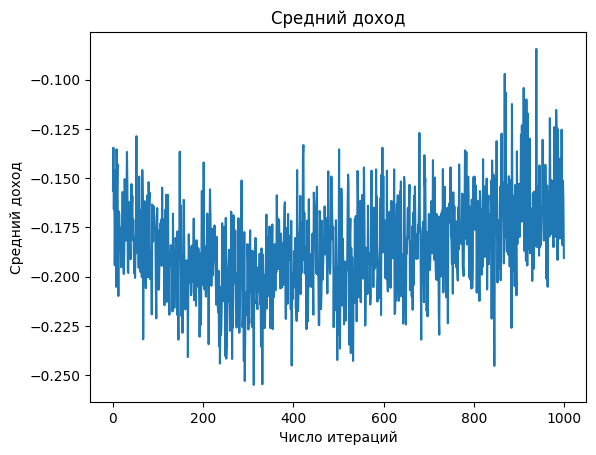

In [36]:
plot()

В итоге у меня получилось так, что с подсчетом карт средняя награда меньше. Но я думаю, если поиграться с параметрами побольше, то данная стратегия покажет себя лучше. Но, с другой стороны, мне кажется невозможно получить среднюю награду больше 0, иначе все бы играли в блек джек :)  
В целом сравнивая графики видно, что стратегия с подсчетом карт показывает себя лучше. 